In [117]:
import pandas as pd
import numpy as np
import warnings
import concurrent.futures
#import missingno as msno
import MetaTrader5 as mt5

pd.options.display.max_columns = 100000
warnings.filterwarnings('ignore')

if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MT5 successfully initialised.\n")

MT5 successfully initialised.



In [118]:
# Defining flag values
TICK_FLAG_BID = 2
TICK_FLAG_ASK = 4
TICK_FLAG_LAST = 8
TICK_FLAG_VOLUME = 16
TICK_FLAG_BUY = 32
TICK_FLAG_SELL = 64

def interpret_flags(flags):
    interpretations = []
    if flags & TICK_FLAG_BID:
        interpretations.append("TICK_FLAG_BID")
    if flags & TICK_FLAG_ASK:
        interpretations.append("TICK_FLAG_ASK")
    if flags & TICK_FLAG_LAST:
        interpretations.append("TICK_FLAG_LAST")
    if flags & TICK_FLAG_VOLUME:
        interpretations.append("TICK_FLAG_VOLUME")
    if flags & TICK_FLAG_BUY:
        interpretations.append("TICK_FLAG_BUY")
    if flags & TICK_FLAG_SELL:
        interpretations.append("TICK_FLAG_SELL")

    return interpretations

# Test with a flag value
flags_value = 376
interpreted_flags = interpret_flags(flags_value)
print(f"Interpretation of {flags_value} is {interpreted_flags}.")


Interpretation of 376 is ['TICK_FLAG_LAST', 'TICK_FLAG_VOLUME', 'TICK_FLAG_BUY', 'TICK_FLAG_SELL'].


In [119]:
df = pd.DataFrame(mt5.copy_ticks_from('AAX[A]',1, 500000, mt5.COPY_TICKS_TRADE))
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

FLAGS = {
    "TICK_FLAG_BID": 2,
    "TICK_FLAG_ASK": 4,
    "TICK_FLAG_LAST": 8,
    "TICK_FLAG_VOLUME": 16,
    "TICK_FLAG_BUY": 32,
    "TICK_FLAG_SELL": 64
}

def decode_flags(flags):
    return [int(bool(flags & flag_value)) for flag_value in FLAGS.values()]

# Creating new columns for each flag
for flag_name in FLAGS:
    df[flag_name] = 0

df[list(FLAGS.keys())] = df['flags'].apply(lambda x: pd.Series(decode_flags(x)))
#drop columns with all zeros
df = df.loc[:, (df != 0).any(axis=0)]
#drop columns last and volume
df = df.drop(['TICK_FLAG_LAST', 'TICK_FLAG_VOLUME'], axis=1)
tick_df = df.copy()
df.tail(25)

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
time,,,,,,,
2023-08-28 16:54:28,2.48,12000,1693241668814,312,12000.0,1,0
2023-08-28 16:54:41,2.48,7300,1693241681009,344,7300.0,0,1
2023-08-28 16:54:42,2.48,1400,1693241682316,344,1400.0,0,1
2023-08-28 16:54:48,2.48,1000,1693241688736,344,1000.0,0,1
2023-08-28 16:55:00,2.48,400,1693241700675,344,400.0,0,1
2023-08-28 16:55:17,2.48,1500,1693241717374,344,1500.0,0,1
2023-08-28 16:55:23,2.48,100,1693241723880,312,100.0,1,0
2023-08-28 16:55:52,2.48,1000,1693241752003,312,1000.0,1,0
2023-08-28 16:56:07,2.48,2000,1693241767797,312,2000.0,1,0


In [120]:
df.describe()

,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
count,121167.000000,1.211670e+05,1.211670e+05,121167.000000,1.211670e+05,121167.000000,121167.000000
mean,1.673726,1.065540e+04,1.684378e+12,328.531498,1.065540e+04,0.553426,0.481592
std,0.469932,2.586968e+04,4.989011e+09,18.095210,2.586968e+04,0.497139,0.499663
min,0.655000,1.000000e+02,1.675443e+12,312.000000,1.000000e+02,0.000000,0.000000
25%,1.340000,1.000000e+03,1.679566e+12,312.000000,1.000000e+03,0.000000,0.000000
50%,1.680000,3.000000e+03,1.684318e+12,312.000000,3.000000e+03,1.000000,0.000000
75%,2.000000,1.000000e+04,1.689672e+12,344.000000,1.000000e+04,1.000000,1.000000
max,2.630000,1.343300e+06,1.693242e+12,376.000000,1.343300e+06,1.000000,1.000000


In [121]:
#df['flags'].value_counts(normalize=True)

# Every 9am + previous 1 row

In [122]:
# # Identify rows at 09:00:00
# mask_0900_indices = df.index[df.index.time == pd.Timestamp('09:00:00').time()]

# # Create an empty mask with all False values
# final_mask = pd.Series(False, index=df.index)

# # For each 09:00:00 timestamp, mark the row and its immediate predecessor
# for timestamp in mask_0900_indices:
#     idx = df.index.get_loc(timestamp)
    
#     # Check if idx is a slice (due to duplicate timestamps)
#     if isinstance(idx, slice):
#         start, stop = idx.start, idx.stop
#         final_mask.iloc[start-1:stop+1] = True
#     else:
#         # Set the current and previous index to True
#         final_mask.iloc[idx-1:idx+1] = True

# # Filter the dataframe using the final mask
# filtered_df = df[final_mask]

# filtered_df.tail(30)


# Every 9am top 5 ticks

In [123]:
n = 5

# Create a mask initialized with False values
final_mask = pd.Series(False, index=df.index)

# Group the dataframe by date and apply the mask for the first n rows of each group
for _, group in df.groupby(df.index.date):
    # Get integer positions or slice
    start_loc = df.index.get_loc(group.index[0])
    
    # If start_loc is a slice (due to duplicate timestamps)
    if isinstance(start_loc, slice):
        start = start_loc.start
    else:
        start = start_loc

    end = start + n

    if group.index[0].time() == pd.Timestamp('09:00:00').time():
        final_mask.iloc[start:end] = True

filtered_df = df[final_mask]
filtered_df.head(30)



,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL
time,,,,,,,
2023-02-07 09:00:00,0.735,23400,1675760400000,312,23400.0,1,0
2023-02-07 09:01:20,0.735,5300,1675760480326,312,5300.0,1,0
2023-02-07 09:02:23,0.735,1000,1675760543834,312,1000.0,1,0
2023-02-07 09:07:37,0.730,10000,1675760857445,344,10000.0,0,1
2023-02-07 09:08:23,0.730,10000,1675760903180,344,10000.0,0,1
2023-02-08 09:00:00,0.705,30000,1675846800000,312,30000.0,1,0
2023-02-08 09:03:04,0.705,7200,1675846984799,344,7200.0,0,1
2023-02-08 09:13:25,0.710,1000,1675847605947,312,1000.0,1,0
2023-02-08 09:25:08,0.710,3000,1675848308831,312,3000.0,1,0


In [124]:

df = pd.DataFrame(filtered_df)
df.index = pd.to_datetime(df.index)
df['date'] = df.index.date

# Calculate product of volume and last
df['volume_last'] = df['volume'] * df['last']

# Group by date to calculate sums
result = df.groupby('date').agg(
    volume_last_sum=('volume_last', 'sum'),
    start_time=('volume', 'first'),
    end_time=('volume', 'last'),
    buy_sum=('TICK_FLAG_BUY', 'sum'),
    sell_sum=('TICK_FLAG_SELL', 'sum')
)

# Using first() and last() to get first and last timestamps respectively
result['start_time'] = df.groupby('date').apply(lambda x: x.index[0])
result['end_time'] = df.groupby('date').apply(lambda x: x.index[-1])

result['time_diff'] = (result['end_time'] - result['start_time']).dt.total_seconds()
result['speed'] = (result['volume_last_sum'] / (result['time_diff'])*388)

result[['volume_last_sum', 'buy_sum', 'sell_sum', 'time_diff', 'speed']]


,volume_last_sum,buy_sum,sell_sum,time_diff,speed
date,,,,,
2023-02-07,36429.5,3,2,503.0,2.810069e+04
2023-02-08,29982.5,3,2,1508.0,7.714330e+03
2023-02-09,215040.0,4,2,726.0,1.149250e+05
2023-02-10,29957.0,3,2,668.0,1.740017e+04
2023-02-13,30174.0,1,4,2742.0,4.269698e+03
...,...,...,...,...,...
2023-08-21,24151.0,3,3,340.0,2.756055e+04
2023-08-23,118098.0,4,1,82.0,5.588052e+05
2023-08-24,203328.0,4,3,101.0,7.811016e+05


In [125]:
result.describe()

,volume_last_sum,buy_sum,sell_sum,time_diff,speed
count,1.320000e+02,132.000000,132.000000,132.000000,1.320000e+02
mean,2.236575e+05,2.780303,2.469697,220.871212,8.335751e+06
std,2.600752e+05,1.326848,1.356012,473.621365,2.326824e+07
min,4.330000e+03,0.000000,0.000000,1.000000,2.430240e+03
25%,4.930325e+04,2.000000,2.000000,28.500000,1.253509e+05
50%,1.141465e+05,3.000000,2.500000,83.000000,4.863390e+05
75%,2.922075e+05,4.000000,3.000000,176.500000,3.378135e+06
max,1.229050e+06,5.000000,5.000000,3573.000000,1.589571e+08


In [126]:
# Calculate the daily percentage change in 'speed'
result['speed_pct_change'] = result['speed'].pct_change()

# Define the Buy, Sell, Hold signals based on conditions
threshold = 0.10  # 10% threshold for speed change
n_consecutive = 4

result['signal'] = 'Hold'
result.loc[(result['speed_pct_change'] > threshold) & (result['buy_sum'] > result['sell_sum']+n_consecutive), 'signal'] = 'Buy'
result.loc[(result['speed_pct_change'] < -threshold) & (result['sell_sum'] > result['buy_sum']+n_consecutive), 'signal'] = 'Sell'

result#[['volume_last_sum', 'buy_sum', 'sell_sum', 'speed', 'speed_pct_change', 'signal']]
print(len(result[result['signal'] == 'Buy']))


11


In [127]:
# filter the signal = Buy or Sell
result[result['signal'] != 'Hold']

,volume_last_sum,start_time,end_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
date,,,,,,,,,
2023-03-22,205824.0,2023-03-22 09:00:00,2023-03-22 09:00:24,0,5,24.0,3.327488e+06,-0.876647,Sell
2023-03-23,617872.0,2023-03-23 09:00:00,2023-03-23 09:00:10,5,0,10.0,2.397343e+07,6.204664,Buy
2023-04-04,274630.0,2023-04-04 09:00:00,2023-04-04 09:00:08,5,0,8.0,1.331956e+07,0.887851,Buy
2023-04-07,244494.0,2023-04-07 09:00:00,2023-04-07 09:00:11,5,0,11.0,8.623970e+06,43.517973,Buy
2023-04-26,223872.0,2023-04-26 09:00:00,2023-04-26 09:00:46,5,0,46.0,1.888312e+06,1.355033,Buy
2023-05-09,318843.0,2023-05-09 09:00:00,2023-05-09 09:02:00,5,0,120.0,1.030926e+06,5.782724,Buy
2023-05-19,816998.0,2023-05-19 09:00:00,2023-05-19 09:00:11,5,0,11.0,2.881775e+07,9.237093,Buy
2023-06-02,53010.0,2023-06-02 09:00:00,2023-06-02 09:02:25,0,5,145.0,1.418474e+05,-0.943800,Sell
2023-06-15,107532.0,2023-06-15 09:00:00,2023-06-15 09:02:19,5,0,139.0,3.001613e+05,1.006864,Buy


In [128]:
import pandas as pd

# Assuming you have the two dataframes already
result_df = result.copy()
result_df = result_df.set_index('end_time')
tick_df = tick_df.copy()
merged_df = pd.merge(left=tick_df, right=result_df, left_index=True, right_index=True, how='left')
merged_df = merged_df.sort_index()
merged_df = merged_df[merged_df['TICK_FLAG_SELL'] == 1]
print(f'len(merged_df): {len(merged_df)}')

def backtest(merged_df, tp_ticks=1, sl_ticks=5):
    entry_price = None
    direction = None  # "Buy" or "Sell"
    tp = tp_ticks * 0.005
    sl = sl_ticks * 0.005
    pnl = 0
    trades = []
    
    for idx, (next_idx, row) in enumerate(zip(merged_df.index[1:], merged_df.iloc[:-1].iterrows())):
        _, row = row
        
        signal = row['signal']
        next_row = merged_df.iloc[idx + 1]
        
        if pd.isnull(signal):
            continue
        
        if entry_price is None:  # if not in a trade
            if signal == 'Buy':
                direction = "Buy"
                entry_price = next_row['last']
                entry_time = next_idx
                tp_price = entry_price + tp
                sl_price = entry_price - sl

            # elif signal == 'Sell':
            #     direction = "Sell"
            #     entry_price = next_row['last']
            #     entry_time = next_idx
            #     tp_price = entry_price - tp
            #     sl_price = entry_price + sl
        
        # check if TP or SL hit in the next row
        if entry_price is not None:
            exit_time = merged_df.index[idx + 2] if idx + 2 < len(merged_df) else None

            if direction == "Buy":

                print(f"Checking TP/SL for Buy at index: {next_idx}")
                print(f"Current Last Price: {next_row['last']}")
                print(f"TP Price: {tp_price}")
                print(f"SL Price: {sl_price}")

                if next_row['last'] >= tp_price or next_row['last'] <= sl_price:
                    trades.append({
                        'entry_timestamp': entry_time,
                        'exit_timestamp': exit_time,
                        'entry': entry_price,
                        'exit': next_row['last'],
                        'pnl': next_row['last'] - entry_price,
                        'type': 'TP' if next_row['last'] >= tp_price else 'SL',
                        'direction': direction
                    })
                    pnl += next_row['last'] - entry_price
                    entry_price = None
                    direction = None

            # elif direction == "Sell":
            #     if next_row['last'] <= tp_price or next_row['last'] >= sl_price:
            #         trades.append({
            #             'entry_timestamp': entry_time,
            #             'exit_timestamp': exit_time,
            #             'entry': entry_price,
            #             'exit': next_row['last'],
            #             'pnl': entry_price - next_row['last'],
            #             'type': 'TP' if next_row['last'] <= tp_price else 'SL',
            #             'direction': direction
            #         })
            #         pnl += entry_price - next_row['last']
            #         entry_price = None
            #         direction = None

    # Convert the trades list to a DataFrame
    trades_df = pd.DataFrame(trades)

    return trades_df, pnl

trades_df, pnl = backtest(merged_df)
print(f"Total PnL: {pnl}")
trades_df


len(merged_df): 58353
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:10
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 1.435
Checking TP/SL for Buy at index: 2023-03-23 09:00:18
Current Last Price: 1.46
TP Price: 1.4649999999999999
SL Price: 

,entry_timestamp,exit_timestamp,entry,exit,pnl,type,direction
0,2023-03-23 09:00:10,2023-03-27 09:00:51,1.46,1.19,-0.27,SL,Buy
1,2023-04-26 09:00:46,2023-04-27 09:07:57,1.32,1.33,0.01,TP,Buy
2,2023-05-19 09:00:20,2023-05-30 09:00:37,1.82,2.04,0.22,TP,Buy
3,2023-07-17 09:00:16,2023-07-20 09:03:59,1.64,1.68,0.04,TP,Buy
4,2023-08-10 09:00:11,2023-08-11 09:03:01,2.46,2.40,-0.06,SL,Buy


In [112]:
trades_df.type.value_counts(normalize=True)

TP    0.6
SL    0.4
Name: type, dtype: float64

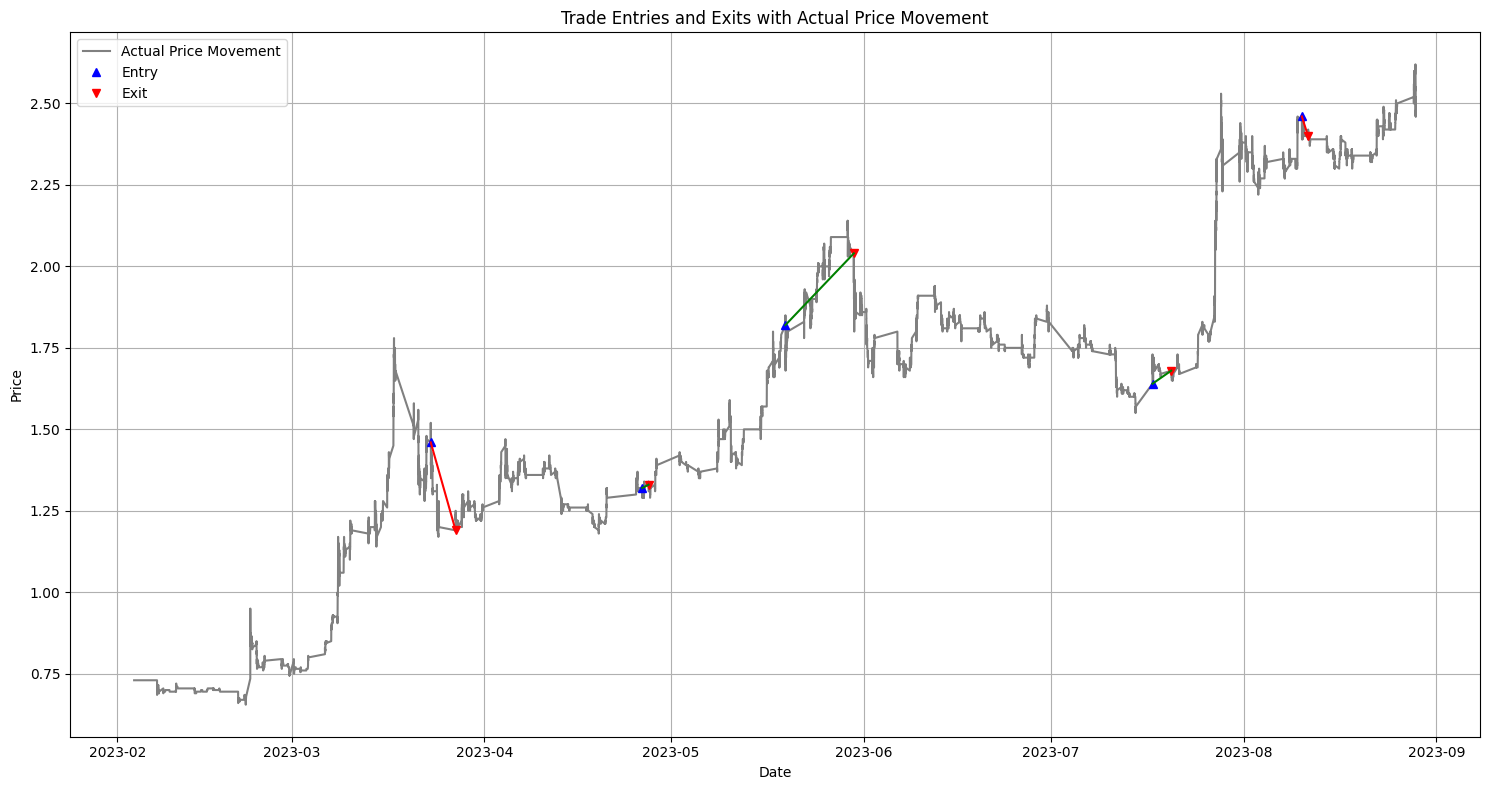

In [113]:
import matplotlib.pyplot as plt

# Convert string timestamps to datetime objects and set them as indices
trades_df['entry_timestamp'] = pd.to_datetime(trades_df['entry_timestamp'])
trades_df['exit_timestamp'] = pd.to_datetime(trades_df['exit_timestamp'])
trades_df = trades_df.set_index('entry_timestamp')  # Using entry_timestamp as index for plotting

# Convert UNIX timestamp (in milliseconds) to datetime and set it as the index
merged_df['time_msc'] = pd.to_datetime(merged_df['time_msc'], unit='ms')
merged_df = merged_df.set_index('time_msc')

# Plotting
plt.figure(figsize=(15, 8))

# Plotting 'last' column from merged_df
plt.plot(merged_df.index, merged_df['last'], color='grey', label='Actual Price Movement')

# Plot entry and exit points from trades_df
plt.plot(trades_df.index, trades_df['entry'], '^', color='blue', label='Entry')
plt.plot(trades_df['exit_timestamp'], trades_df['exit'], 'v', color='red', label='Exit')

# Indicating TP and SL with green and red lines respectively
for _, row in trades_df.iterrows():
    if row['type'] == 'TP':
        plt.plot([row.name, row['exit_timestamp']], [row['entry'], row['exit']], color='green')
    elif row['type'] == 'SL':
        plt.plot([row.name, row['exit_timestamp']], [row['entry'], row['exit']], color='red')

plt.title('Trade Entries and Exits with Actual Price Movement')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [114]:
result_df = result.copy()
#set end_time as index
result_df = result_df.set_index('end_time')
result_df

,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
end_time,,,,,,,,
2023-02-07 09:08:23,36429.5,2023-02-07 09:00:00,3,2,503.0,2.810069e+04,NaN,Hold
2023-02-08 09:25:08,29982.5,2023-02-08 09:00:00,3,2,1508.0,7.714330e+03,-0.725475,Hold
2023-02-09 09:12:06,215040.0,2023-02-09 09:00:00,4,2,726.0,1.149250e+05,13.897594,Hold
2023-02-10 09:11:08,29957.0,2023-02-10 09:00:00,3,2,668.0,1.740017e+04,-0.848595,Hold
2023-02-13 09:45:42,30174.0,2023-02-13 09:00:00,1,4,2742.0,4.269698e+03,-0.754618,Hold
...,...,...,...,...,...,...,...,...
2023-08-21 09:05:40,24151.0,2023-08-21 09:00:00,3,3,340.0,2.756055e+04,-0.972943,Hold
2023-08-23 09:01:22,118098.0,2023-08-23 09:00:00,4,1,82.0,5.588052e+05,19.275543,Hold
2023-08-24 09:01:41,203328.0,2023-08-24 09:00:00,4,3,101.0,7.811016e+05,0.397807,Hold


In [115]:
import pandas as pd



# Merge based on the indexes (datetime) of both tick_df and result_df using a left merge
merged_df = pd.merge(left=tick_df, right=result_df, left_index=True, right_index=True, how='left')

# Sorting by the index (which is the time from tick_df)
merged_df = merged_df.sort_index()
merged_df


,last,volume,time_msc,flags,volume_real,TICK_FLAG_BUY,TICK_FLAG_SELL,volume_last_sum,start_time,buy_sum,sell_sum,time_diff,speed,speed_pct_change,signal
2023-02-03 16:55:05,0.730,5000,1675443305531,312,5000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-03 16:55:06,0.730,300,1675443306223,344,300.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:00:00,0.735,23400,1675760400000,312,23400.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:01:20,0.735,5300,1675760480326,312,5300.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-07 09:02:23,0.735,1000,1675760543834,312,1000.0,1,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28 16:58:00,2.480,2600,1693241880365,344,2600.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-28 16:58:19,2.480,100,1693241899947,344,100.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-28 16:58:25,2.480,2000,1693241905695,344,2000.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-28 16:58:48,2.480,3000,1693241928729,344,3000.0,0,1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
